## Download LJSpeech

In [ ]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
!tar -xjf LJSpeech-1.1.tar.bz2

--2021-12-16 18:22:53--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 174.138.79.61
Connecting to data.keithito.com (data.keithito.com)|174.138.79.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [application/octet-stream]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  96.1MB/s    in 31s     

2021-12-16 18:23:24 (85.4 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



In [ ]:
!pip install librosa

In [ ]:
!pip install torch==1.10.0+cu111 torchaudio==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


## Featurizer

In [1]:
from IPython import display
from dataclasses import dataclass

import torch
from torch import nn

import torchaudio

import librosa
from matplotlib import pyplot as plt


@dataclass
class MelSpectrogramConfig:
    sr: int = 22050
    win_length: int = 1024
    hop_length: int = 256
    n_fft: int = 1024
    f_min: int = 0
    f_max: int = 8000
    n_mels: int = 80
    power: float = 1.0

    # value of melspectrograms if we fed a silence into `MelSpectrogram`
    pad_value: float = -11.5129251


class MelSpectrogram(nn.Module):

    def __init__(self, config: MelSpectrogramConfig):
        super(MelSpectrogram, self).__init__()

        self.config = config

        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=config.sr,
            win_length=config.win_length,
            hop_length=config.hop_length,
            n_fft=config.n_fft,
            f_min=config.f_min,
            f_max=config.f_max,
            n_mels=config.n_mels
        )

        # The is no way to set power in constructor in 0.5.0 version.
        self.mel_spectrogram.spectrogram.power = config.power

        # Default `torchaudio` mel basis uses HTK formula. In order to be compatible with WaveGlow
        # we decided to use Slaney one instead (as well as `librosa` does by default).
        mel_basis = librosa.filters.mel(
            sr=config.sr,
            n_fft=config.n_fft,
            n_mels=config.n_mels,
            fmin=config.f_min,
            fmax=config.f_max
        ).T
        self.mel_spectrogram.mel_scale.fb.copy_(torch.tensor(mel_basis))

    def forward(self, audio: torch.Tensor) -> torch.Tensor:
        """
        :param audio: Expected shape is [B, T]
        :return: Shape is [B, n_mels, T']
        """

        mel = self.mel_spectrogram(audio) \
            .clamp_(min=1e-5) \
            .log_()

        return mel

In [2]:
featurizer = MelSpectrogram(MelSpectrogramConfig())

---

## Dataset

In [3]:
class LJSpeechDataset(torchaudio.datasets.LJSPEECH):

    def __init__(self, root):
        super().__init__(root=root)
        self._tokenizer = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_CHAR_LJSPEECH.get_text_processor()

    def __getitem__(self, index: int):
        waveform, _, _, transcript = super().__getitem__(index)
        waveforn_length = torch.tensor([waveform.shape[-1]]).int()
        
        tokens, token_lengths = self._tokenizer(transcript)
        
        return waveform, waveforn_length, transcript, tokens, token_lengths
    
    def decode(self, tokens, lengths):
        result = []
        for tokens_, length in zip(tokens, lengths):
            text = "".join([
                self._tokenizer.tokens[token]
                for token in tokens_[:length]
            ])
            result.append(text)
        return result
                

In [4]:
dataset = LJSpeechDataset('.')

In [5]:
dataset[0]

(tensor([[-7.3242e-04, -7.6294e-04, -6.4087e-04,  ...,  7.3242e-04,
           2.1362e-04,  6.1035e-05]]),
 tensor([212893], dtype=torch.int32),
 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition',
 tensor([[27, 29, 20, 25, 31, 20, 25, 18,  6, 11, 20, 25, 11, 31, 19, 16, 11, 26,
          25, 23, 36, 11, 30, 16, 25, 30, 16, 11, 34, 20, 31, 19, 11, 34, 19, 20,
          14, 19, 11, 34, 16, 11, 12, 29, 16, 11, 12, 31, 11, 27, 29, 16, 30, 16,
          25, 31, 11, 14, 26, 25, 14, 16, 29, 25, 16, 15,  6, 11, 15, 20, 17, 17,
          16, 29, 30, 11, 17, 29, 26, 24, 11, 24, 26, 30, 31, 11, 20, 17, 11, 25,
          26, 31, 11, 17, 29, 26, 24, 11, 12, 23, 23, 11, 31, 19, 16, 11, 12, 29,
          31, 30, 11, 12, 25, 15, 11, 14, 29, 12, 17, 31, 30, 11, 29, 16, 27, 29,
          16, 30, 16, 25, 31, 16, 15, 11, 20, 25, 11, 31, 19, 16, 11, 16, 35, 19,
          20, 13, 20, 31, 20, 26, 25]]),
 t

In [6]:
from typing import Tuple, Dict, Optional, List, Union
from itertools import islice

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


@dataclass
class Batch:
    waveform: torch.Tensor
    waveforn_length: torch.Tensor
    transcript: List[str]
    tokens: torch.Tensor
    token_lengths: torch.Tensor
    durations: Optional[torch.Tensor] = None
        
    def to(self, device: torch.device) -> 'Batch':
        raise NotImplementedError


class LJSpeechCollator:

    def __call__(self, instances: List[Tuple]) -> Dict:
        waveform, waveforn_length, transcript, tokens, token_lengths = list(
            zip(*instances)
        )

        waveform = pad_sequence([
            waveform_[0] for waveform_ in waveform
        ]).transpose(0, 1)
        waveforn_length = torch.cat(waveforn_length)

        tokens = pad_sequence([
            tokens_[0] for tokens_ in tokens
        ]).transpose(0, 1)
        token_lengths = torch.cat(token_lengths)

        return Batch(waveform, waveforn_length, transcript, tokens, token_lengths)

In [7]:
dataloader = DataLoader(LJSpeechDataset('.'), batch_size=3, collate_fn=LJSpeechCollator())

In [8]:
dummy_batch = list(islice(dataloader, 1))[0]
dummy_batch

Batch(waveform=tensor([[-0.0007, -0.0008, -0.0006,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0003,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0025, -0.0037,  0.0005,  ...,  0.0003,  0.0002, -0.0004]]), waveforn_length=tensor([212893,  41885, 213149], dtype=torch.int32), transcript=('Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', 'in being comparatively modern.', 'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process'), tokens=tensor([[27, 29, 20, 25, 31, 20, 25, 18,  6, 11, 20, 25, 11, 31, 19, 16, 11, 26,
         25, 23, 36, 11, 30, 16, 25, 30, 16, 11, 34, 20, 31, 19, 11, 34, 19, 20,
         14, 19, 11, 34, 16, 11, 12, 29, 16, 11, 12, 31, 11, 27, 29, 16, 30, 16,
         25, 31, 11, 14, 26, 25, 14, 16, 29, 25, 16, 15,  6, 11, 15, 20, 17, 17,
         16,

## Generator

In [9]:
import torch.nn.functional as F


class ConvBlock(nn.Module):
    def __init__(self, hidden_size, kernel_size, dilation):
        super(ConvBlock, self).__init__()

        self.net = nn.Sequential(
            nn.LeakyReLU(),
            nn.Conv1d(
                hidden_size,
                hidden_size,
                kernel_size,
                stride=1,
                dilation=dilation,
                padding=(kernel_size - 1) * dilation // 2
            ),
            nn.LeakyReLU(),
            nn.Conv1d(
                hidden_size,
                hidden_size,
                kernel_size,
                stride=1,
                dilation=1,
                padding=(kernel_size - 1) // 2
            ),
        )

    def forward(self, x):
        return self.net(x)


class ResBlock(nn.Module):
    def __init__(self, hidden_size, kernel_size=3, dilation=(1, 3, 5)):
        super(ResBlock, self).__init__()
        
        self.net = nn.ModuleList(
            [ConvBlock(hidden_size, kernel_size, d) for d in dilation]
        )

    def forward(self, x):
        for cb in self.net:
            x = cb(x) + x
        return x


class MRF(nn.Module):
    def __init__(self, hidden_size, kernel_sizes, dilations):
        super(MRF, self).__init__()

        self.resblocks = nn.ModuleList(
            [
                ResBlock(hidden_size, k, d)
                for k, d in zip(kernel_sizes, dilations)
            ]
        )


    def forward(self, x):
        xs = None
        for resblock in self.resblocks:
            if xs is None:
                xs = resblock(x)
            else:
                xs += resblock(x)
        return xs / len(self.resblocks)



class Generator(nn.Module):
    def __init__(self, config):
        super(Generator, self).__init__()

        self.num_upsamples = len(config.upsample_rates)

        self.conv_pre = nn.Conv1d(80, config.first_hidden_size, 7, 1, padding=3)
        self.convs = nn.ModuleList(
            [
                nn.ConvTranspose1d(
                    config.first_hidden_size // 2**i,
                    config.first_hidden_size // 2**(i + 1),
                    kernel_size=upblock_kernel_size,
                    stride=upblock_stride,
                    padding=(upblock_kernel_size - upblock_stride) // 2,
                )
                for i, (upblock_kernel_size, upblock_stride) in enumerate(zip(
                    config.upsample_kernel_sizes, config.upsample_rates
                ))
            ]
        )

        self.MRFs = nn.ModuleList(
            [
                MRF(
                    config.first_hidden_size // 2**(i + 1),
                    config.resblock_kernel_sizes,
                    config.resblock_dilation_sizes,
                )
                for i in range(self.num_upsamples)
            ]
        )

        self.fc = nn.Conv1d(
            config.first_hidden_size // 2**self.num_upsamples,
            1, kernel_size=7, stride=1, padding=3
        )

    def forward(self, x):
        x = self.conv_pre(x)
        for conv, mrf in zip(self.convs, self.MRFs):
            x = F.leaky_relu(x)
            x = conv(x)
            x = mrf(x)
        x = F.leaky_relu(x)
        x = self.fc(x)
        x = torch.tanh(x)

        return x

In [10]:
dummy_batch.mels = featurizer(dummy_batch.waveform).cuda()

In [11]:
dummy_batch.mels.size()

torch.Size([3, 80, 833])

In [12]:
from dataclasses import dataclass

@dataclass
class GeneratorConfig:
    first_hidden_size: int = 512
    upsample_kernel_sizes = (16,16,4,4)
    upsample_rates = (8,8,2,2)
    resblock_kernel_sizes = (3,7,11)
    resblock_dilation_sizes = ((1,3,5), (1,3,5), (1,3,5))

In [13]:
generator = Generator(GeneratorConfig).cuda()

In [14]:
waveform = dummy_batch.waveform[:1]
mels = featurizer(waveform).cuda()

In [36]:
from tqdm import tqdm


NUM_EPOCHS = 1000


optimizer = torch.optim.Adam(params=generator.parameters(), lr=2e-4, betas=(.8, .99), eps=1e-9)
generator.train()

for e in tqdm(range(NUM_EPOCHS)):
    optimizer.zero_grad()

    waveform_preds = generator(dummy_batch.mels).squeeze()
    loss = nn.L1Loss()(waveform_preds[:, :dummy_batch.waveform.size(1)], dummy_batch.waveform.cuda())

    loss.backward()
    optimizer.step()

    if e % 10 == 9:
        print('Epoch {}. Loss: {}'.format(e+1, loss.item()))

  1%|          | 10/1000 [00:11<19:40,  1.19s/it]

Epoch 10. Loss: 0.044610731303691864


  2%|▏         | 20/1000 [00:23<19:31,  1.20s/it]

Epoch 20. Loss: 0.04398835450410843


  3%|▎         | 30/1000 [00:35<19:20,  1.20s/it]

Epoch 30. Loss: 0.04380694776773453


  4%|▍         | 40/1000 [00:47<19:07,  1.20s/it]

Epoch 40. Loss: 0.04341130331158638


  5%|▌         | 50/1000 [00:59<18:55,  1.20s/it]

Epoch 50. Loss: 0.04269786924123764


  6%|▌         | 60/1000 [01:11<18:43,  1.20s/it]

Epoch 60. Loss: 0.043267201632261276


  7%|▋         | 70/1000 [01:23<18:31,  1.20s/it]

Epoch 70. Loss: 0.04122460260987282


  8%|▊         | 80/1000 [01:35<18:18,  1.19s/it]

Epoch 80. Loss: 0.04019397124648094


  9%|▉         | 90/1000 [01:47<18:05,  1.19s/it]

Epoch 90. Loss: 0.03823185712099075


 10%|█         | 100/1000 [01:59<17:54,  1.19s/it]

Epoch 100. Loss: 0.03684079274535179


 11%|█         | 110/1000 [02:11<17:42,  1.19s/it]

Epoch 110. Loss: 0.03505707159638405


 12%|█▏        | 120/1000 [02:23<17:31,  1.19s/it]

Epoch 120. Loss: 0.03307481110095978


 13%|█▎        | 130/1000 [02:35<17:19,  1.19s/it]

Epoch 130. Loss: 0.03363654762506485


 14%|█▍        | 140/1000 [02:47<17:06,  1.19s/it]

Epoch 140. Loss: 0.02767469733953476


 15%|█▌        | 150/1000 [02:59<16:55,  1.19s/it]

Epoch 150. Loss: 0.02415347844362259


 16%|█▌        | 160/1000 [03:11<16:42,  1.19s/it]

Epoch 160. Loss: 0.022545810788869858


 17%|█▋        | 170/1000 [03:22<16:31,  1.20s/it]

Epoch 170. Loss: 0.020092492923140526


 18%|█▊        | 180/1000 [03:34<16:19,  1.19s/it]

Epoch 180. Loss: 0.019879192113876343


 19%|█▉        | 190/1000 [03:46<16:07,  1.19s/it]

Epoch 190. Loss: 0.017794327810406685


 20%|██        | 200/1000 [03:58<15:55,  1.19s/it]

Epoch 200. Loss: 0.017124680802226067


 21%|██        | 210/1000 [04:10<15:42,  1.19s/it]

Epoch 210. Loss: 0.015261241234838963


 22%|██▏       | 220/1000 [04:22<15:30,  1.19s/it]

Epoch 220. Loss: 0.014937925152480602


 23%|██▎       | 230/1000 [04:34<15:18,  1.19s/it]

Epoch 230. Loss: 0.014718135818839073


 24%|██▍       | 240/1000 [04:46<15:07,  1.19s/it]

Epoch 240. Loss: 0.014060799963772297


 25%|██▌       | 250/1000 [04:58<14:55,  1.19s/it]

Epoch 250. Loss: 0.013751307502388954


 26%|██▌       | 260/1000 [05:10<14:43,  1.19s/it]

Epoch 260. Loss: 0.01369738020002842


 27%|██▋       | 270/1000 [05:22<14:31,  1.19s/it]

Epoch 270. Loss: 0.013206320814788342


 28%|██▊       | 280/1000 [05:34<14:18,  1.19s/it]

Epoch 280. Loss: 0.01297375001013279


 29%|██▉       | 290/1000 [05:46<14:07,  1.19s/it]

Epoch 290. Loss: 0.012856905348598957


 30%|███       | 300/1000 [05:58<13:56,  1.19s/it]

Epoch 300. Loss: 0.012311719357967377


 31%|███       | 310/1000 [06:10<13:44,  1.20s/it]

Epoch 310. Loss: 0.012437225319445133


 32%|███▏      | 320/1000 [06:22<13:32,  1.19s/it]

Epoch 320. Loss: 0.01228982862085104


 33%|███▎      | 330/1000 [06:33<13:19,  1.19s/it]

Epoch 330. Loss: 0.012020526453852654


 34%|███▍      | 340/1000 [06:45<13:07,  1.19s/it]

Epoch 340. Loss: 0.011948872357606888


 35%|███▌      | 350/1000 [06:57<12:57,  1.20s/it]

Epoch 350. Loss: 0.01173124834895134


 36%|███▌      | 360/1000 [07:09<12:44,  1.19s/it]

Epoch 360. Loss: 0.011897910386323929


 37%|███▋      | 370/1000 [07:21<12:32,  1.19s/it]

Epoch 370. Loss: 0.011738814413547516


 38%|███▊      | 380/1000 [07:33<12:20,  1.19s/it]

Epoch 380. Loss: 0.011488598771393299


 39%|███▉      | 390/1000 [07:45<12:07,  1.19s/it]

Epoch 390. Loss: 0.011389442719519138


 40%|████      | 400/1000 [07:57<11:55,  1.19s/it]

Epoch 400. Loss: 0.011161468923091888


 41%|████      | 410/1000 [08:09<11:45,  1.20s/it]

Epoch 410. Loss: 0.011197174899280071


 42%|████▏     | 420/1000 [08:21<11:32,  1.19s/it]

Epoch 420. Loss: 0.01134044025093317


 43%|████▎     | 430/1000 [08:33<11:21,  1.20s/it]

Epoch 430. Loss: 0.011364289559423923


 44%|████▍     | 440/1000 [08:45<11:08,  1.19s/it]

Epoch 440. Loss: 0.011152512393891811


 45%|████▌     | 450/1000 [08:57<10:57,  1.19s/it]

Epoch 450. Loss: 0.010997257195413113


 46%|████▌     | 460/1000 [09:09<10:45,  1.19s/it]

Epoch 460. Loss: 0.010987967252731323


 47%|████▋     | 470/1000 [09:21<10:32,  1.19s/it]

Epoch 470. Loss: 0.010834691114723682


 48%|████▊     | 480/1000 [09:33<10:20,  1.19s/it]

Epoch 480. Loss: 0.010861928574740887


 49%|████▉     | 490/1000 [09:44<10:09,  1.19s/it]

Epoch 490. Loss: 0.011198756285011768


 50%|█████     | 500/1000 [09:56<09:56,  1.19s/it]

Epoch 500. Loss: 0.010790403932332993


 51%|█████     | 510/1000 [10:08<09:45,  1.20s/it]

Epoch 510. Loss: 0.010694592259824276


 52%|█████▏    | 520/1000 [10:20<09:32,  1.19s/it]

Epoch 520. Loss: 0.01023934781551361


 53%|█████▎    | 530/1000 [10:32<09:22,  1.20s/it]

Epoch 530. Loss: 0.010224295780062675


 54%|█████▍    | 540/1000 [10:44<09:09,  1.19s/it]

Epoch 540. Loss: 0.009887969121336937


 55%|█████▌    | 550/1000 [10:56<08:56,  1.19s/it]

Epoch 550. Loss: 0.00991680659353733


 56%|█████▌    | 560/1000 [11:08<08:45,  1.19s/it]

Epoch 560. Loss: 0.009930605068802834


 57%|█████▋    | 570/1000 [11:20<08:33,  1.19s/it]

Epoch 570. Loss: 0.010056374594569206


 58%|█████▊    | 580/1000 [11:32<08:21,  1.19s/it]

Epoch 580. Loss: 0.010166429914534092


 59%|█████▉    | 590/1000 [11:44<08:09,  1.19s/it]

Epoch 590. Loss: 0.009812384843826294


 60%|██████    | 600/1000 [11:56<07:57,  1.19s/it]

Epoch 600. Loss: 0.009526563808321953


 61%|██████    | 610/1000 [12:08<07:45,  1.19s/it]

Epoch 610. Loss: 0.009449359960854053


 62%|██████▏   | 620/1000 [12:20<07:34,  1.19s/it]

Epoch 620. Loss: 0.00957376416772604


 63%|██████▎   | 630/1000 [12:32<07:21,  1.19s/it]

Epoch 630. Loss: 0.00975776556879282


 64%|██████▍   | 640/1000 [12:44<07:09,  1.19s/it]

Epoch 640. Loss: 0.009445047937333584


 65%|██████▌   | 650/1000 [12:55<06:57,  1.19s/it]

Epoch 650. Loss: 0.00912005826830864


 66%|██████▌   | 660/1000 [13:07<06:45,  1.19s/it]

Epoch 660. Loss: 0.009362277574837208


 67%|██████▋   | 670/1000 [13:19<06:33,  1.19s/it]

Epoch 670. Loss: 0.009214334189891815


 68%|██████▊   | 680/1000 [13:31<06:21,  1.19s/it]

Epoch 680. Loss: 0.00916841346770525


 69%|██████▉   | 690/1000 [13:43<06:09,  1.19s/it]

Epoch 690. Loss: 0.009098629467189312


 70%|███████   | 700/1000 [13:55<05:58,  1.19s/it]

Epoch 700. Loss: 0.00891751330345869


 71%|███████   | 710/1000 [14:07<05:45,  1.19s/it]

Epoch 710. Loss: 0.008968660607933998


 72%|███████▏  | 720/1000 [14:19<05:34,  1.19s/it]

Epoch 720. Loss: 0.00907974038273096


 73%|███████▎  | 730/1000 [14:31<05:22,  1.19s/it]

Epoch 730. Loss: 0.008824365213513374


 74%|███████▍  | 740/1000 [14:43<05:10,  1.19s/it]

Epoch 740. Loss: 0.008695556782186031


 75%|███████▌  | 750/1000 [14:55<04:58,  1.19s/it]

Epoch 750. Loss: 0.008617167361080647


 76%|███████▌  | 760/1000 [15:07<04:46,  1.19s/it]

Epoch 760. Loss: 0.008844646625220776


 77%|███████▋  | 770/1000 [15:19<04:34,  1.19s/it]

Epoch 770. Loss: 0.008690139278769493


 78%|███████▊  | 780/1000 [15:31<04:22,  1.19s/it]

Epoch 780. Loss: 0.008568312972784042


 79%|███████▉  | 790/1000 [15:43<04:10,  1.19s/it]

Epoch 790. Loss: 0.008364571258425713


 80%|████████  | 800/1000 [15:54<03:58,  1.19s/it]

Epoch 800. Loss: 0.008480590768158436


 81%|████████  | 810/1000 [16:06<03:46,  1.19s/it]

Epoch 810. Loss: 0.00848845113068819


 82%|████████▏ | 820/1000 [16:18<03:35,  1.19s/it]

Epoch 820. Loss: 0.008437721990048885


 83%|████████▎ | 830/1000 [16:30<03:23,  1.19s/it]

Epoch 830. Loss: 0.008243010379374027


 84%|████████▍ | 840/1000 [16:42<03:10,  1.19s/it]

Epoch 840. Loss: 0.008592881262302399


 85%|████████▌ | 850/1000 [16:54<02:58,  1.19s/it]

Epoch 850. Loss: 0.008265577256679535


 86%|████████▌ | 860/1000 [17:06<02:47,  1.19s/it]

Epoch 860. Loss: 0.00815255381166935


 87%|████████▋ | 870/1000 [17:18<02:35,  1.19s/it]

Epoch 870. Loss: 0.008334504440426826


 88%|████████▊ | 880/1000 [17:30<02:23,  1.19s/it]

Epoch 880. Loss: 0.008237079717218876


 89%|████████▉ | 890/1000 [17:42<02:11,  1.19s/it]

Epoch 890. Loss: 0.008151800371706486


 90%|█████████ | 900/1000 [17:54<01:59,  1.19s/it]

Epoch 900. Loss: 0.008303473703563213


 91%|█████████ | 910/1000 [18:06<01:47,  1.19s/it]

Epoch 910. Loss: 0.008296084590256214


 92%|█████████▏| 920/1000 [18:18<01:35,  1.19s/it]

Epoch 920. Loss: 0.008073713630437851


 93%|█████████▎| 930/1000 [18:30<01:23,  1.19s/it]

Epoch 930. Loss: 0.008010882884263992


 94%|█████████▍| 940/1000 [18:42<01:11,  1.19s/it]

Epoch 940. Loss: 0.007986510172486305


 95%|█████████▌| 950/1000 [18:54<00:59,  1.19s/it]

Epoch 950. Loss: 0.007915172725915909


 96%|█████████▌| 960/1000 [19:05<00:47,  1.19s/it]

Epoch 960. Loss: 0.008193743415176868


 97%|█████████▋| 970/1000 [19:17<00:35,  1.19s/it]

Epoch 970. Loss: 0.00798812322318554


 98%|█████████▊| 980/1000 [19:29<00:23,  1.19s/it]

Epoch 980. Loss: 0.008116327226161957


 99%|█████████▉| 990/1000 [19:41<00:11,  1.19s/it]

Epoch 990. Loss: 0.008028429001569748


100%|██████████| 1000/1000 [19:53<00:00,  1.19s/it]

Epoch 1000. Loss: 0.008091213181614876


In [37]:
generator.eval()
reconstructed_wav = generator(mels)[0].detach().cpu()

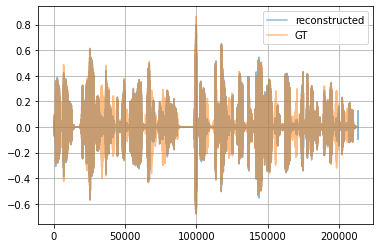

In [38]:
plt.plot(reconstructed_wav.squeeze(), label='reconstructed', alpha=.5)
plt.plot(waveform.squeeze(), label='GT', alpha=.5)
plt.grid()
plt.legend()
plt.show()

In [39]:
display.display(display.Audio(waveform, rate=22050))
display.display(display.Audio(reconstructed_wav, rate=22050))